In [40]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from lxml import html
import requests

# 1. Data Import

In [63]:
DATA_DIR = 'data/1k';
DATA_PATH = '1k.csv'

def getPaper(id):
    # gets the abstract and title from citeulike based on an id
    page = requests.get('http://www.citeulike.org/article-posts/' + str(id))
    tree = html.fromstring(page.content)
    title = tree.xpath('//h1/text()')[0] if len(tree.xpath('//h1/text()')) else ''
    abstract = tree.xpath('//*[@id="abstract-body"]/blockquote/p/text()')[0] if len(tree.xpath('//*[@id="abstract-body"]/blockquote/p/text()')) else ''
    return {'title': title, 'abstract': abstract}

In [43]:
def readCiteULikeData(path):
    # read the csv into pandas
    data = pd.read_csv(path, header=0, sep=",")
    # data.drop(data.columns[[2,3]], axis=1, inplace=True) ---- not needed anymore
    
    # the way the data is currently laid out means that there is a new row for each tag a user added to a paper.
    # thus, we need to collapse rows referring to the same user and item into one row. 
    #drops = []
    #for i in range(1, len(data.index)):
    #    current = data.loc[i]
    #    prev = data.loc[i-1]
    #    if ((current.Id == prev.Id) & (current.Username == prev.Username)):
    #        drops.append(i)

    #data = data.drop(data.index[drops])
    
    data['Id'] = data['Id'].astype(object)
    
    data.columns = ['iid', 'uid']
    
    return data

In [44]:
def filterByMinItems(data, min):
    good_users = data.groupby('uid', as_index=False).filter(lambda x: len(x) > min - 1)['uid'].tolist()
    data = data[data['uid'].isin(good_users)].reset_index(drop=True)
    return data

In [64]:
data = pd.read_csv(os.path.join(DATA_DIR, DATA_PATH), header=0, sep=",")
data.head()

,Id,Username
0,42,61baaeba8de136d9c1aa9c18ec3860e8
1,43,61baaeba8de136d9c1aa9c18ec3860e8
2,44,61baaeba8de136d9c1aa9c18ec3860e8
3,45,61baaeba8de136d9c1aa9c18ec3860e8
4,46,61baaeba8de136d9c1aa9c18ec3860e8


In [65]:
data = readCiteULikeData(os.path.join(DATA_DIR, DATA_PATH))

print '----------------- \n    SUMMARY \n-----------------'
print '# of users:', data['uid'].describe()['unique']
print '# of docs: ', data['iid'].describe()['unique']

----------------- 
    SUMMARY 
-----------------
# of users: 133
# of docs:  922


In [66]:
data['uid'].value_counts().to_csv(os.path.join(DATA_DIR, 'user_distribution.csv'))

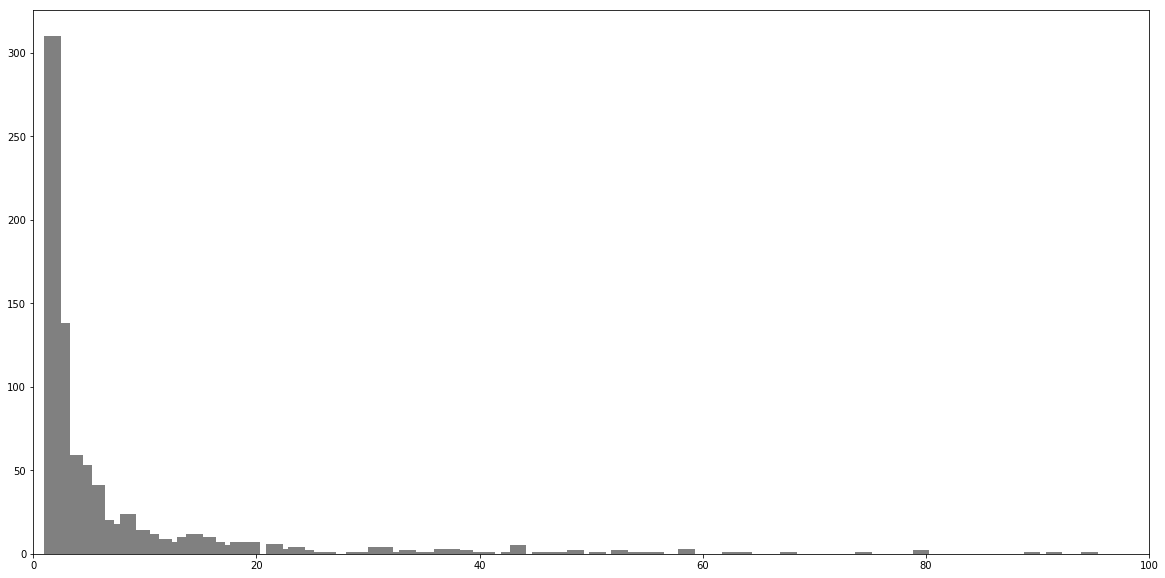

In [50]:
# plotting user-count distribution
plt.figure(figsize=(20,10))
plt.hist(data['uid'].value_counts(), 1000, facecolor='gray', color='white', width=1.5)
plt.xlim([0, 100])
plt.show()

In [67]:
#data = filterByMinItems(data, 35)

print '----------------- \n    SUMMARY \n-----------------'
print '# of users:', data['uid'].describe()['unique']
print '# of docs: ', data['iid'].describe()['unique']

----------------- 
    SUMMARY 
-----------------
# of users: 133
# of docs:  922


# 2. Processing

In [68]:
def indexIds(data):
    # convert user and item id's into matrix indices
    uid_to_index = {}
    iid_to_index = {}
    index_to_iid = {}
    index_to_uid = {}
    i_index = 0
    u_index = 0
    for i in range(0, len(data)):
        user = data.loc[i, 'uid']
        item = data.loc[i, 'iid']
        if not user in uid_to_index:
            uid_to_index[user] = u_index
            index_to_uid[u_index] = user
            u_index += 1
        if not item in iid_to_index:
            iid_to_index[item] = i_index
            index_to_iid[i_index] = item
            i_index += 1
        data.loc[i, 'uid'] = uid_to_index[user]
        data.loc[i, 'iid'] = iid_to_index[item]
    
    return (data, index_to_uid, index_to_iid)

In [69]:
(data, index_to_uid, index_to_iid) = indexIds(data)

In [70]:
data.head()

,iid,uid
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [54]:
def getDocuments(data, index_to_iid):
    # generate lookup table of document words
    item_words = {}
    n = len(data.index)
    for i in range(0, n):
        item_index = data.loc[i, 'iid']
        if not item_index in item_words:
            print "\r{0}".format((float(i)/n)*100), 'percent complete.',
            paper = getPaper(index_to_iid[item_index])
            item_words[item_index] = (paper['title'] + paper['abstract']).encode("utf-8")
    print "\r{0}".format((float(1)/1)*100), 'percent complete',
    return item_words

In [71]:
documents = getDocuments(data, index_to_iid)
print 'Documents seem to be correctly done:', len(documents) == len(set(data['iid'].tolist()))

100.0 percent complete Documents seem to be correctly done: Truercent complete.                                                               percent complete.                               percent complete.   percent complete.                  percent complete.               percent complete.                              percent complete.                        percent complete.                                                                            


In [72]:
pd.DataFrame.from_dict(documents, orient="index").to_csv(os.path.join(DATA_DIR, 'documents.csv'), index=False)

In [73]:
# need to split into training/validation and test
# will ignore time for now, not sure whether we have it
def formatDataset(p, data): 
    """Generates a training set from a full data set

    Parameters
    ----------
    n : int
        number of items to include in each user's training library

    data: 2d pandas data frame
        'iid', 'uid' columns
        
    Returns
    -------
    data : 2d pandas data frame including 'class' column (factors 'train', 'test')
    """
    user_totals = {}
    for i in range(0, len(data.index)-1):
        user = data.loc[i, 'uid']
        if not user in user_totals:
            user_totals[user] = 0
        user_totals[user] += 1
    
    counts = {}
    for i in range(0, len(data.index)-1):
        user = data.loc[i, 'uid']
        item = data.loc[i, 'iid']
        if not user in counts:
            counts[user] = 0
        if counts[user] < p * user_totals[user]:
            counts[user] += 1
            data.loc[i, 'class'] = 'train'
        else:
            data.loc[i, 'class'] = 'test'
    
    return data

In [74]:
TRAINING_PROPORTION = 0.8
data = formatDataset(TRAINING_PROPORTION, data)
data.groupby('class').count()

,iid,uid
class,,
test,154,154
train,844,844


In [75]:
data.describe()

,iid,uid,class
count,999,999,998
unique,922,133,2
top,833,48,train
freq,4,235,844


In [76]:
data.to_csv(os.path.join(DATA_DIR, 'ratings.csv'), index=False)

In [77]:
data.head()

,iid,uid,class
0,0,0,train
1,1,0,train
2,2,0,train
3,3,0,train
4,4,0,train


In [80]:
recall = {'10': 0.0030075187969924814, '12': 0.010526315789473684, '20': 0.010526315789473684, '14': 0.010526315789473684, '16': 0.010526315789473684, '18': 0.010526315789473684, '2': 0.0, '4': 0.0, '6': 0.0, '8': 0.0015037593984962407}
precision = {'10': 0.0015037593984962407, '12': 0.0018796992481203006, '20': 0.0011278195488721805, '14': 0.0016111707841031148, '16': 0.0014097744360902255, '18': 0.0012531328320802004, '2': 0.0, '4': 0.0, '6': 0.0, '8': 0.00093984962406015032}

In [81]:
recall = pd.DataFrame.from_dict(recall)
precision = pd.DataFrame.from_dict(precision)

ValueError: If using all scalar values, you must pass an index